# **Space X  Falcon 9 First Stage Landing Prediction**


### Objectives
- Collect and clean SpaceX Falcon 9 launch data.  
- Perform exploratory data analysis (EDA).  
- Define the target label for first stage landing success.  
- Preprocess features for modeling.  
- Train machine learning models and tune hyperparameters.  
- Evaluate models and identify key features that influence landing success.  


## Preparation


In [1]:
import pandas as pd              
import numpy as np               
from datetime import datetime
from scipy.stats import trim_mean, kurtosis, skew, boxcox, yeojohnson      
from math import sqrt
import matplotlib                
import matplotlib.pyplot as plt  
from pandas.plotting import parallel_coordinates
import seaborn as sns            
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score,
                             f1_score, confusion_matrix, classification_report)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna

## Data Cleaning


In [3]:
df=pd.read_csv('/kaggle/input/spacex-launch-scraped-dataset/spacex_web_scraped.csv')
df.head(10)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,"CCAFS , SLC-40",Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure [ 9 ] [ 10 ] (parachute),4 June 2010,18:45
1,2,"CCAFS , SLC-40",Dragon demo flight C1 (Dragon C101),0,LEO ( ISS ),NASA ( COTS ) NRO,Success,F9 v1.07B0004.18,Failure [ 9 ] [ 14 ] (parachute),8 December 2010,15:43
2,3,"CCAFS , SLC-40",Dragon demo flight C2+ [ 18 ] (Dragon C102),525 kg,LEO ( ISS ),NASA ( COTS ),Success,F9 v1.07B0005.18,No attempt,22 May 2012,07:44
3,4,"CCAFS , SLC-40",SpaceX CRS-1 [ 22 ] (Dragon C103),"4,700 kg",LEO ( ISS ),NASA ( CRS ),Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,"CCAFS , SLC-40",SpaceX CRS-2 [ 22 ] (Dragon C104),"4,877 kg",LEO ( ISS ),NASA ( CRS ),Success\n,F9 v1.07B0007.18,No attempt,1 March 2013,15:10
5,6,"VAFB , SLC-4E",CASSIOPE [ 22 ] [ 31 ],500 kg,Polar orbit LEO,MDA,Success,F9 v1.17B10038,Uncontrolled (ocean) [ d ],29 September 2013,16:00
6,7,"CCAFS , SLC-40",SES-8 [ 22 ] [ 35 ] [ 36 ],"3,170 kg",GTO,SES,Success,F9 v1.1 B1004,No attempt [ 38 ],3 December 2013,22:41
7,8,"CCAFS , SLC-40",Thaicom 6 [ 22 ],"3,325 kg",GTO,Thaicom,Success,F9 v1.1,No attempt [ 43 ],6 January 2014,22:06
8,9,"Cape Canaveral , LC-40",SpaceX CRS-3 [ 22 ] (Dragon C105),"2,296 kg",LEO ( ISS ),NASA ( CRS ),Success\n,F9 v1.1,Controlled (ocean) [ d ] [ 46 ],18 April 2014,19:25
9,10,"Cape Canaveral , LC-40",Orbcomm-OG2 -1 (6 satellites) [ 22 ],"1,316 kg",LEO,Orbcomm,Success,F9 v1.1,Controlled (ocean) [ d ] [ 46 ],14 July 2014,15:15


Identify and calculate the percentage of the missing values in each attribute


In [4]:
df.isnull().sum()/len(df)*100

Flight No.         0.0
Launch site        0.0
Payload            0.0
Payload mass       0.0
Orbit              0.0
Customer           0.0
Launch outcome     0.0
Version Booster    0.0
Booster landing    0.0
Date               0.0
Time               0.0
dtype: float64

Identify which columns are numerical and categorical:


In [5]:
df.dtypes

Flight No.          int64
Launch site        object
Payload            object
Payload mass       object
Orbit              object
Customer           object
Launch outcome     object
Version Booster    object
Booster landing    object
Date               object
Time               object
dtype: object

In [6]:
df.describe

<bound method NDFrame.describe of      Flight No.             Launch site  \
0             1          CCAFS , SLC-40   
1             2          CCAFS , SLC-40   
2             3          CCAFS , SLC-40   
3             4          CCAFS , SLC-40   
4             5          CCAFS , SLC-40   
..          ...                     ...   
116         117          CCSFS , SLC-40   
117         118    KSC , LC-39A [ 661 ]   
118         119  CCSFS , SLC-40 [ 665 ]   
119         120            KSC , LC-39A   
120         121          CCSFS , SLC-40   

                                               Payload Payload mass  \
0                 Dragon Spacecraft Qualification Unit            0   
1                  Dragon demo flight C1 (Dragon C101)            0   
2          Dragon demo flight C2+ [ 18 ] (Dragon C102)       525 kg   
3                    SpaceX CRS-1 [ 22 ] (Dragon C103)     4,700 kg   
4                    SpaceX CRS-2 [ 22 ] (Dragon C104)     4,877 kg   
..                     

**Observations**

* Data has 121 rows x 11 columns.
* Detected 1 numeric column and 10 non-numeric columns.
* Numeric: Flight No.
* Non-numeric: Launch site, Payload, Payload mass, Orbit, Customer, Launch outcome, Version Booster, Booster * landing, Date, Time
* Null values: 0 columns with missing values by pandas detection.

**Payload mass**  
   - Current values include `"kg"`.  
   - Convert this column to numeric by removing `"kg"` and turning it into `float`.


In [7]:
# Drop rows where Payload mass is 'C'
df = df[df['Payload mass'].str.strip().str.lower() != 'c'].copy()

# Clean Payload mass and convert to float
df['Payload mass'] = (
    df['Payload mass']
      .str.replace('kg','', regex=False)
      .str.replace(',','', regex=False)
      .str.replace(r'[~≈]', '', regex=True)
      .str.extract(r'(\d+\.?\d*)')[0]
      .astype(float)
)

**Launch outcome**  
   - Contains both `"Success\n"` and `"success"`.  
   - Standardize them to `"Success"`.  
   - Keep `"Failure"` unchanged.

In [8]:
df['Launch outcome'] = df['Launch outcome'].str.strip().str.capitalize()

**Booster landing**  
   - Values have extra information in square brackets `[ ... ]` and parentheses `( ... )`.  
   - Extract only the main outcome: `"Success"`, `"Failure"`, `"No attempt"`, `"Controlled"`, `"Uncontrolled"`.

In [9]:
df['Booster landing'] = (
    df['Booster landing']
    .str.replace(r"\[.*?\]", "", regex=True)
    .str.replace(r"\(.*?\)", "", regex=True)
    .str.strip()
)

     
**Launch site**  
   - Values also contain trailing `[ ... ]`
   - Clean them by removing everything in square brackets


In [10]:
df['Launch site'] = (
    df['Launch site']
    .str.replace(r"\[.*?\]", "", regex=True)
    .str.strip()
)

In [11]:
print(df[['Payload mass','Launch outcome','Booster landing','Launch site']].head(10))

   Payload mass Launch outcome Booster landing             Launch site
0           0.0        Success         Failure          CCAFS , SLC-40
1           0.0        Success         Failure          CCAFS , SLC-40
2         525.0        Success      No attempt          CCAFS , SLC-40
3        4700.0        Success      No attempt          CCAFS , SLC-40
4        4877.0        Success      No attempt          CCAFS , SLC-40
5         500.0        Success    Uncontrolled           VAFB , SLC-4E
6        3170.0        Success      No attempt          CCAFS , SLC-40
7        3325.0        Success      No attempt          CCAFS , SLC-40
8        2296.0        Success      Controlled  Cape Canaveral , LC-40
9        1316.0        Success      Controlled  Cape Canaveral , LC-40


## EDA

### Univariate Analysis

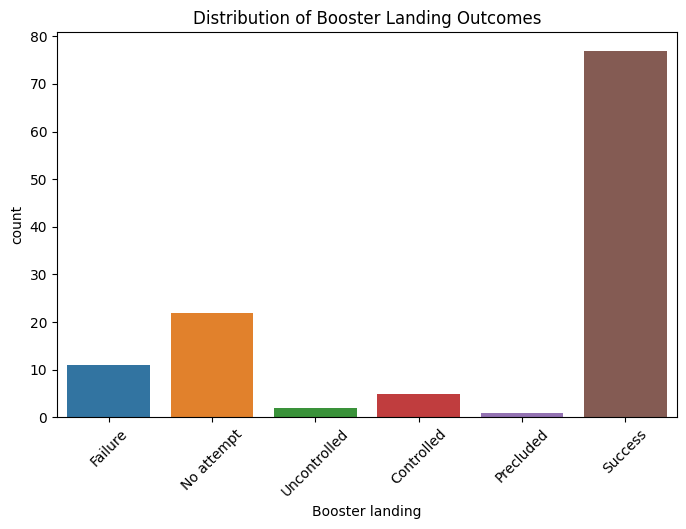

In [12]:
# Plot distribution of Booster landing
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Booster landing')
plt.title("Distribution of Booster Landing Outcomes")
plt.xticks(rotation=45)
plt.show()

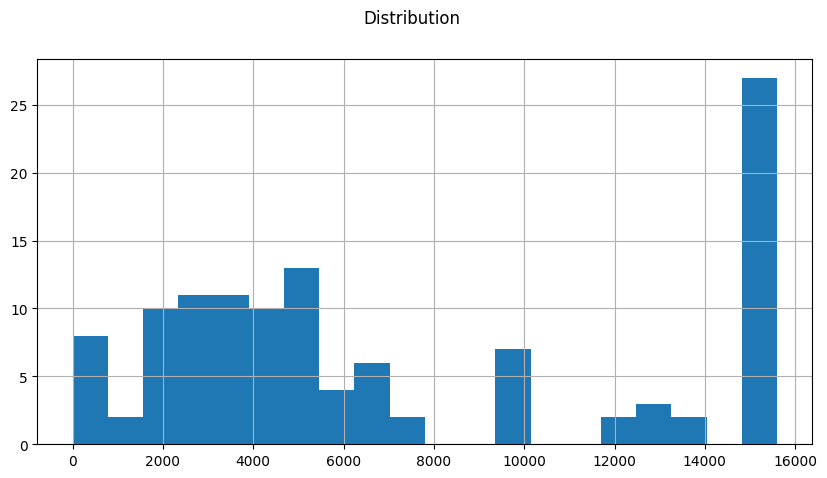

In [13]:
# Plot histograms
df['Payload mass'].hist(bins=20, figsize=(10,5))
plt.suptitle("Distribution")
plt.show()

### Log Transform on Payload Mass

The distribution of Payload mass is highly skewed, with many large values.  
To make the distribution easier to visualize and analyze, we apply a log transform using `np.log1p`.  
This transformation reduces skewness and helps us better understand patterns in the data.


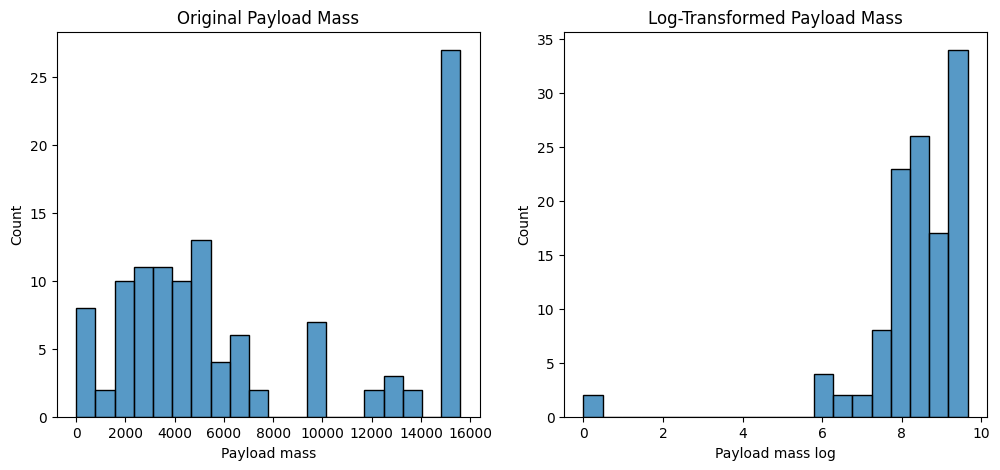

In [14]:
# Apply log transform
df['Payload mass log'] = np.log1p(df['Payload mass'])

# Compare before and after
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df['Payload mass'], bins=20, ax=axes[0])
axes[0].set_title("Original Payload Mass")

sns.histplot(df['Payload mass log'], bins=20, ax=axes[1])
axes[1].set_title("Log-Transformed Payload Mass")

plt.show()

## Preprocessing

### Train/Test Split

In [15]:
# Simplify target to binary
df['Landing binary'] = df['Booster landing'].apply(lambda x: 'Success' if x == 'Success' else 'Other')

X = df.drop(columns=['Booster landing', 'Landing binary', 'Flight No.'])
y = df['Landing binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Label Encoder

In [16]:
# Encode target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Split columns
cat_cols = [col for col in X.columns if X[col].dtype == "object"]
num_cols = [col for col in X.columns if X[col].dtype != "object"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Transform data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Modeling & Hyperparameter Tuning

### Logistic Regression

In [17]:
#def obj_lr(trial):
#    params = {
#        "C": trial.suggest_float("C", 1e-3, 10, log=True),
#        "solver": trial.suggest_categorical("solver", ["liblinear", "lbfgs"]),
#        "max_iter": 2000,
#        "class_weight": "balanced"
#    }
#    model = LogisticRegression(**params)
#    # compute both accuracy and f1, then combine or choose one
#    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy").mean()
#    f1  = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1").mean()
#    return (acc + f1) / 2   # balance between accuracy and f1
#
#study_lr = optuna.create_study(direction="maximize")
#study_lr.optimize(obj_lr, n_trials=30, show_progress_bar=False)
#
#best_lr = LogisticRegression(**study_lr.best_params, max_iter=2000, class_weight="balanced")
#best_lr.fit(X_train, y_train)
#print("LR best params:", study_lr.best_params)
#evaluate(best_lr, X_test, y_test)
#

LR best params: {'C': 7.205397061182992, 'solver': 'lbfgs'}

Accuracy: 0.667  Precision: 0.786  Recall: 0.688  F1: 0.733  ROC AUC: 0.750

In [18]:
# Create Logistic Regression
lr = LogisticRegression(
    C=7.205397061182992,
    solver='lbfgs',
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

# Perform cross-validation 
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model on the full training data
lr.fit(X_train, y_train)

# Predict on validation/test data
y_pred = lr.predict(X_test)

# Calculate accuracy on validation/test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Cross-Validation Scores: [0.68421053 0.78947368 0.73684211 0.73684211 0.55555556]
Mean CV Score: 0.7005847953216374
Accuracy on Test Data: 0.6666666666666666


### Decision Tree

In [19]:
#def objective(trial):
#    params = {
#        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
#        "max_depth": trial.suggest_int("max_depth", 4, 20),
#        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
#        "max_features": trial.suggest_float("max_features", 0.3, 1.0),
#        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#        "random_state": 42,
#        "n_jobs": -1
#    }
#    model = RandomForestClassifier(**params)
#    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
#    return score
#
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=30, show_progress_bar=False)
#
#rf_best = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
#rf_best.fit(X_train, y_train)
#print("RF best params:", study.best_params)
#evaluate(rf_best, X_test, y_test)

RF best params: {'n_estimators': 223, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.9477983453966339, 'bootstrap': True} 

Accuracy: 0.708 Precision: 0.737 Recall: 0.875 F1: 0.800 ROC AUC: 0.801

In [20]:
# Create Random Forest
rf = RandomForestClassifier(
    n_estimators=223,
    max_depth=19,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features=0.9477983453966339,
    bootstrap=True,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model on the full training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Cross-Validation Scores: [0.73684211 0.73684211 0.73684211 0.63157895 0.72222222]
Mean CV Score: 0.7128654970760234
Accuracy on Test Data: 0.7083333333333334


### SVM

In [21]:
#def obj_svm(trial):
#    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
#    params = {
#        "C": trial.suggest_float("C", 1e-2, 100, log=True),
#        "kernel": kernel,
#        "gamma": "scale" if kernel == "linear" else trial.suggest_float("gamma", 1e-4, 1.0, log=True),
#        "probability": True,
#        "class_weight": "balanced",
#        "random_state": 42
#    }
#    model = SVC(**params)
#    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy").mean()
#    f1  = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1").mean()
#    return (acc + f1) / 2   # balance both
#
#study_svm = optuna.create_study(direction="maximize")
#study_svm.optimize(obj_svm, n_trials=30, show_progress_bar=False)
#
#best_svm = SVC(**study_svm.best_params, probability=True, class_weight="balanced", random_state=42)
#best_svm.fit(X_train, y_train)
#print("SVM best params:", study_svm.best_params)
#evaluate(best_svm, X_test, y_test)

SVM best params: {'kernel': 'linear', 'C': 15.123296760564935}

Accuracy: 0.792  Precision: 0.824  Recall: 0.875  F1: 0.848  ROC AUC: 0.750

In [22]:
# Create SVM
svm = SVC(
    kernel='linear',
    C=15.123296760564935,
    probability=True,
    class_weight="balanced",
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model
svm.fit(X_train, y_train)

# Predict on test data
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Cross-Validation Scores: [0.78947368 0.78947368 0.73684211 0.73684211 0.61111111]
Mean CV Score: 0.7327485380116959
Accuracy on Test Data: 0.7916666666666666


### Neural Networks

In [23]:
# If sparse input, convert to dense
Xtr_mlp = X_train.toarray() if hasattr(X_train, "toarray") else X_train
Xte_mlp = X_test.toarray() if hasattr(X_test, "toarray") else X_test

In [24]:
#def obj_mlp(trial):
#    hidden = trial.suggest_categorical("hidden_layer_sizes", [(32,), (64,), (64,32)])
#    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
#    lr = trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True)
#    model = MLPClassifier(hidden_layer_sizes=hidden, alpha=alpha,
#                          learning_rate_init=lr, max_iter=500, random_state=42)
#    acc = cross_val_score(model, Xtr_mlp, y_train, cv=cv, scoring="accuracy").mean()
#    f1  = cross_val_score(model, Xtr_mlp, y_train, cv=cv, scoring="f1").mean()
#    return (acc + f1) / 2
#
#study_mlp = optuna.create_study(direction="maximize")
#study_mlp.optimize(obj_mlp, n_trials=30, show_progress_bar=False)
#
#best_mlp = MLPClassifier(**study_mlp.best_params, max_iter=500, random_state=42)
#best_mlp.fit(Xtr_mlp, y_train)
#
#print("Best MLP params:", study_mlp.best_params)
#evaluate(best_mlp, Xte_mlp, y_test)

Best MLP params: {'hidden_layer_sizes': (32,), 'alpha': 0.0001133946272672401, 'learning_rate_init': 0.002396279719995049}

Accuracy: 0.833  Precision: 0.833  Recall: 0.938  F1: 0.882  ROC AUC: 0.727

In [25]:
# Create MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(32,),
    alpha=0.0001133946272672401,
    learning_rate_init=0.002396279719995049,
    max_iter=500,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(mlp, Xtr_mlp, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model
mlp.fit(Xtr_mlp, y_train)

# Predict on test data
y_pred = mlp.predict(Xte_mlp)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Cross-Validation Scores: [0.78947368 0.78947368 0.78947368 0.73684211 0.72222222]
Mean CV Score: 0.7654970760233918
Accuracy on Test Data: 0.8333333333333334


## Important Feature

In [28]:
# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

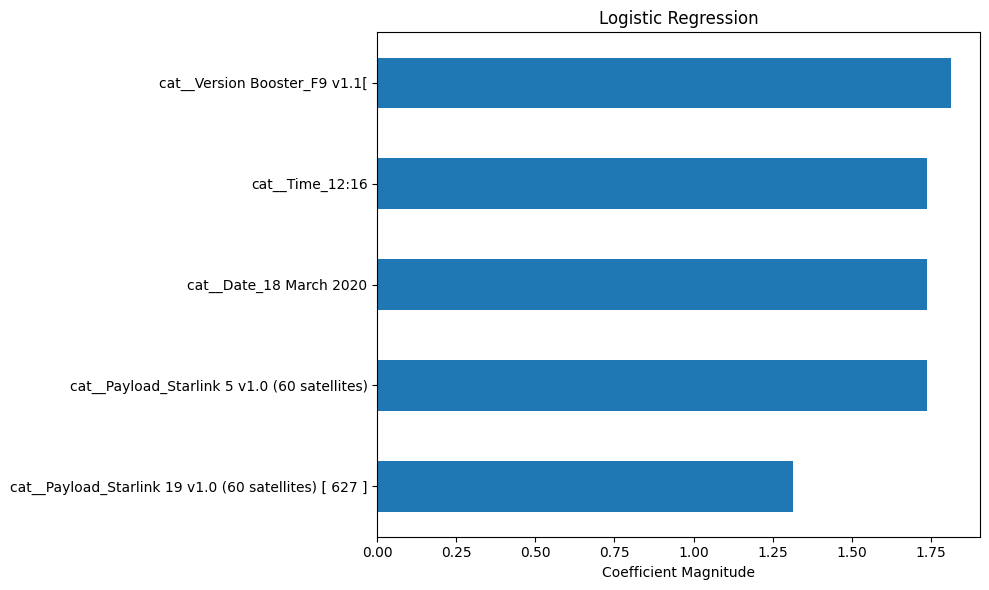

In [38]:
coef = pd.Series(np.abs(lr.coef_[0]), index=feature_names)
coef.nlargest(5).sort_values().plot(kind="barh", figsize=(10,6))
plt.title("Logistic Regression")
plt.xlabel("Coefficient Magnitude")
plt.tight_layout()
plt.show()

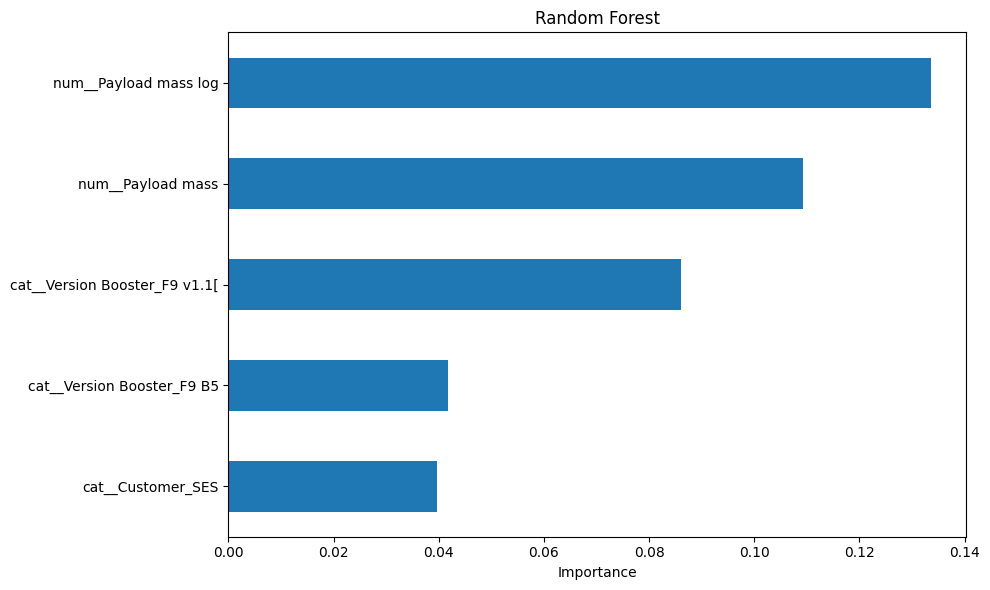

In [34]:
rf_imp = pd.Series(rf.feature_importances_, index=feature_names)
rf_imp.nlargest(5).sort_values().plot(kind="barh", figsize=(10,6))
plt.title("Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()